# End-to-End Multi-Neuron (JAX)

Evaluate N LGN neurons (separable) using BrainState/JAX backend and compare with BMTK per-neuron reference on a small case.

In [12]:
import os, sys, time, statistics as stats
import numpy as np
import matplotlib.pyplot as plt
PKG_ROOT = os.path.abspath(os.path.join('..'))
if PKG_ROOT not in sys.path: sys.path.insert(0, PKG_ROOT)
from brainlgn_x.stimuli import drifting_grating
from brainlgn_x.filters import GaussianSpatialFilter, TemporalFilterCosineBump, SpatioTemporalFilter
from brainlgn_x.transfer import ScalarTransferFunction
from brainlgn_x.bs_backend import eval_separable_multi
from bmtk.simulator.filternet.lgnmodel.lnunit import LNUnit
from bmtk.simulator.filternet.lgnmodel.movie import Movie
try:
    import jax # noqa
    HAVE_JAX=True
except Exception:
    HAVE_JAX=False


## 1) Stimulus

In [13]:
row, col = 64, 128
frame_rate = 1000.0
movie = drifting_grating(row, col, frame_rate, duration=0.4, gray_screen=0.1, cpd=0.04, temporal_f=4.0, theta=0.0, contrast=0.8)
print('Stimulus:', movie.shape, 'frame_rate:', movie.frame_rate)


Stimulus: (500, 64, 128) frame_rate: 1000.0


## 2) Define N neurons with different translates

In [14]:
N=16
translates=[(float(i%8)*2.0, float(i//8)*2.0) for i in range(N)]
sigma=(2.0,2.0)
weights=(0.6,-0.4); kpeaks=(15.0,45.0); delays=(0,0)
amp=2.0; bias=1.0
lfs=[]; trs=[]
for trn in translates:
    spatial=GaussianSpatialFilter(translate=trn, sigma=sigma)
    temporal=TemporalFilterCosineBump(weights=weights, kpeaks=kpeaks, delays=delays)
    lfs.append(SpatioTemporalFilter(spatial, temporal, amplitude=amp))
    trs.append(ScalarTransferFunction(f'Max(0, s + {bias})'))
print('Built', len(lfs), 'filters')


Built 16 filters


## 3) Evaluate with BS multi and BMTK small reference

In [15]:
assert HAVE_JAX, 'JAX not installed for multi-neuron JAX demo'
stim = movie.as_array()
rates_bs = eval_separable_multi(lfs, trs, stim, frame_rate=movie.frame_rate, downsample=1)  # (N,T)
# Small parity check on first 4 neurons vs BMTK
ref=[]
mv = Movie(stim, frame_rate=movie.frame_rate)
for i in range(min(4,N)):
    ln=LNUnit(lfs[i], trs[i])
    t_ref, y_ref = ln.get_cursor(mv, separable=True).evaluate()
    ref.append(np.array(y_ref))
ref=np.stack(ref,axis=0)
mae=np.mean(np.abs(rates_bs[:ref.shape[0]]-ref))
mx =np.max(np.abs(rates_bs[:ref.shape[0]]-ref))
print('Parity (first 4): MAE=%.3e MaxAbs=%.3e' % (mae,mx))


Parity (first 4): MAE=5.018e-08 MaxAbs=5.474e-07


## 4) Timing (multi-neuron, JAX)

In [16]:
def bench(fn, repeats=5, warmup=1):
    for _ in range(warmup): fn()
    ts=[]
    for _ in range(repeats):
        t0=time.perf_counter(); fn(); ts.append(time.perf_counter()-t0)
    return {'mean': stats.mean(ts), 'stdev': (stats.pstdev(ts) if len(ts)>1 else 0.0), 'min': min(ts), 'max': max(ts)}
res = bench(lambda: eval_separable_multi(lfs, trs, stim, frame_rate=movie.frame_rate, downsample=1), repeats=5, warmup=1)
print('Timing BS multi:', res)


Timing BS multi: {'mean': 0.03155479999841191, 'stdev': 0.001414827948213471, 'min': 0.029419500002404675, 'max': 0.033439099992392585}


## 5) Poisson spikes and write outputs (multi)

In [17]:
from brainlgn_x.poisson import generate_inhomogeneous_poisson
from brainlgn_x.io_output import write_spikes_csv, write_spikes_h5, write_rates_h5
dt = 1.0 / movie.frame_rate
gids, times = generate_inhomogeneous_poisson(rates_bs, dt, base_seed=321)
print('Generated spikes (multi):', len(times))
out_dir = os.path.abspath('./_outputs_multi')
os.makedirs(out_dir, exist_ok=True)
write_rates_h5(os.path.join(out_dir, 'rates.h5'), rates_bs, movie.frame_rate)
write_spikes_csv(os.path.join(out_dir, 'spikes.csv'), gids, times)
write_spikes_h5(os.path.join(out_dir, 'spikes.h5'), gids, times)
print('Wrote outputs to:', out_dir)

Generated spikes (multi): 7
Wrote outputs to: c:\Users\76629\OneDrive\brain\repos\brainlgn\brainlgn-X\notebooks\_outputs_multi


## 6) Visualizations (multi)

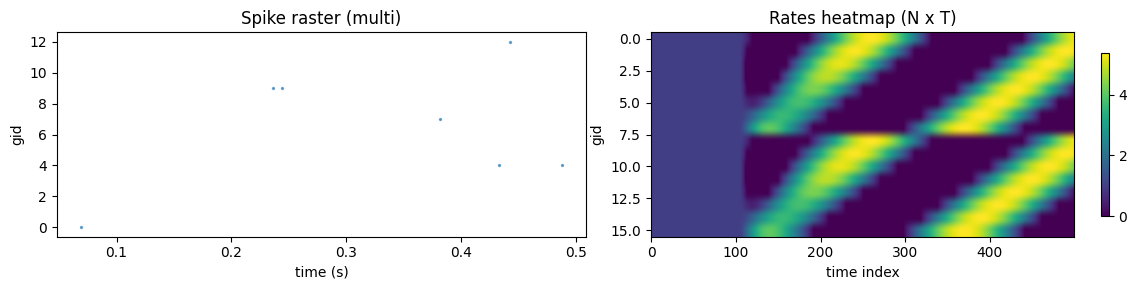

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,3))
# Raster from in-memory spikes (gids,times) produced above
try:
    ax[0].scatter(times, gids, s=2, alpha=0.6)
    ax[0].set_title('Spike raster (multi)')
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('gid')
except Exception as e:
    ax[0].set_title(f'No spikes available: {e}')
    ax[0].axis('off')
# Rates heatmap
try:
    im = ax[1].imshow(rates_bs, aspect='auto', cmap='viridis')
    ax[1].set_title('Rates heatmap (N x T)')
    ax[1].set_xlabel('time index')
    ax[1].set_ylabel('gid')
    fig.colorbar(im, ax=ax[1], shrink=0.8)
except Exception as e:
    ax[1].set_title(f'No rates available: {e}')
    ax[1].axis('off')
plt.tight_layout(); plt.show()

## 7) Compare spikes: BMTK vs BrainState (subset)

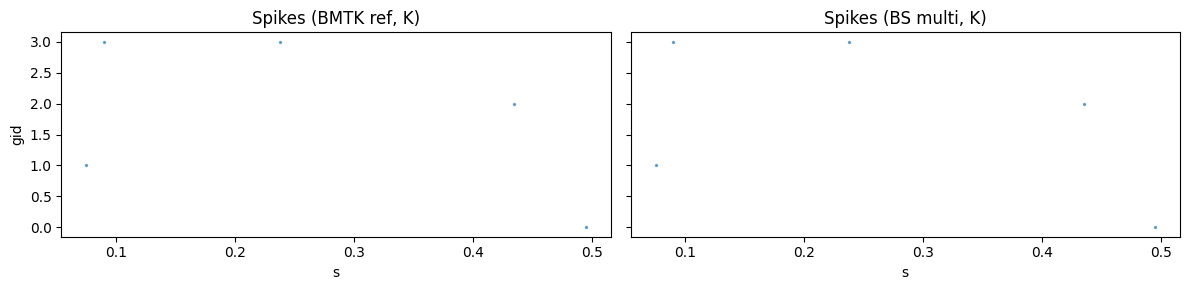

In [19]:
# Compare spikes per backend for the same stimulus using identical seeds
from brainlgn_x.poisson import generate_inhomogeneous_poisson
base_seed = 888
dt = 1.0 / movie.frame_rate
# Build small BMTK reference for first K neurons
K = min(4, rates_bs.shape[0])
from bmtk.simulator.filternet.lgnmodel.lnunit import LNUnit
from bmtk.simulator.filternet.lgnmodel.movie import Movie as BMovie
mv = BMovie(stim, frame_rate=movie.frame_rate)
rates_ref = []
for i in range(K):
    ln = LNUnit(lfs[i], trs[i])
    _, y = ln.get_cursor(mv, separable=True).evaluate()
    rates_ref.append(np.array(y))
rates_ref = np.stack(rates_ref, axis=0)
# Generate spikes for K neurons for both
g_bs, t_bs = generate_inhomogeneous_poisson(rates_bs[:K], dt, base_seed=base_seed)
g_ref, t_ref = generate_inhomogeneous_poisson(rates_ref, dt, base_seed=base_seed)
fig, ax = plt.subplots(1,2, figsize=(12,3), sharey=True)
ax[0].scatter(t_ref, g_ref, s=2, alpha=0.6); ax[0].set_title("Spikes (BMTK ref, K)"); ax[0].set_xlabel("s"); ax[0].set_ylabel("gid")
ax[1].scatter(t_bs,  g_bs,  s=2, alpha=0.6); ax[1].set_title("Spikes (BS multi, K)"); ax[1].set_xlabel("s");
plt.tight_layout(); plt.show()